# Market Basket Analysis and Product Recommandation

## Test 1: Basket analysis and product association in retail
A retail chain of stores is looking to improve their marketing campaigns with data-driven
decision: product promotion based on basket analysis. Your task is to develop a product
association algorithm that will help the marketing department in creating flyers and
custom offers.

The task was broken down into the following steps:

    1.) Step: Understanding the data set  
    2.) Step: Data pre-processing  
    3.) Step: Data visualisation  
    4.) Step: Recommender systems  
    5.) Step: Market Basket Analysis  

### 1.) Step: Understanding the data set

#### Data Set Information:

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a 
UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the 
company are wholesalers.

#### Attributes

InvoiceNo: Number uniquely assigned to each transaction. Code 'c' indicates a cancellation.  
StockCode: Number uniquely assigned to each distinct product  
Description: Product (item) name  
Quantity: The quantities of each product per transaction  
InvoiceDate: Rhe day and time when each transaction was generated  
UnitPrice: Product price per unit in sterling  
CustomerID: Integral number uniquely assigned to each customer  
Country: The name of the country where each customer resides  

Reference: http://archive.ics.uci.edu/ml/datasets/online+retail

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('retail1.csv', parse_dates = ['InvoiceDate'], dtype={'CustomerID': str,'InvoiceNo': str, 'StockCode': str})
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


### 2.) Step: Data pre-processing

In [2]:
#save data shape to track changes
shape = data.shape

# Check data types and missing values
data_info = pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
data_info = data_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'Null values (abs)'}))
data_info = data_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'Null values (%)'}))
data_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
Null values (abs),0,0,166,0,0,0,25281,0
Null values (%),0,0,0.253439,0,0,0,38.5975,0


In [3]:
#Note: 38.5% of CostumerID's and 0.25% of descriptions are missing. Fill in missing values.
data["CustomerID"] = data["CustomerID"].fillna('00000')
data["Description"] = data["Description"].fillna("Unkown")

#UnitPrice and Quantity are numerical values (check statistics)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,65499.0,8.366235,413.808128,-74215.0,1.00,2.00,8.00,74215.00
UnitPrice,65499.0,5.857586,145.795963,0.0,1.25,2.51,4.24,16888.02


In [4]:
# Issues: quantity has negative values while price has null values 

neg_quant = len(data[data['Quantity'] <= 0])/float(len(data))*100
price_zero = len(data[data['UnitPrice'] == 0])/float(len(data))*100

print('Products with: Zero price: {0: .2f}%. Negative quantity: {1: .2f}%'.format(price_zero, neg_quant))

# Note: Allthough only a small percentage of purchases have been registered with erronous values, the source of these
# errors should be further investigated. However, in our analysis, we simply delete them.
data.drop((data[(data['Quantity'] <= 0) | (data['UnitPrice'] == 0)]).index, inplace=True)

Products with: Zero price:  0.51%. Negative quantity:  1.82%


In [5]:
#Track changes
print('{0: .2f}% of the data has been deleted'.format((shape[0]-data.shape[0])/float(data.shape[0])*100))

 2.22% of the data has been deleted


In [6]:
# Perform additional data checks

# 1.) Check if data contains cancelled items
len(data[map(lambda x: 'C' in x, data['InvoiceNo'])])
len(data[map(lambda x: 'c' in x, data['InvoiceNo'])])
# Note: Data does not contain cancelled items


# 2.) Check if nr. of unique descriptions equals unique stockcodes
print('Nr. of unique descriptions: {}'.format(len(data.Description.value_counts()))) 
print('Nr. of unique stock codes: {}'.format(len(data.StockCode.value_counts())))
# After performing deeper analysis, it can not be determined why this descrepency exists

# # Check why number is not equal
# data.groupby('Description').StockCode.nunique()[data.groupby('Description').StockCode.nunique() != 1]
# # Answer: there are items with two codes. Check one example:
# data[data['Description'] == 'RETRO MOD TRAY']
# # Note: From the data alone it can not be determined why some unique descriptions have two stock codes


# 3.) It seems that StockCode contains some special codes besides normal stock codes.
special_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
# These special codes might have to be removed in the future


# 4.) The 'Description' column is text data so it might have trailing spaces
data['Description'] = data['Description'].str.strip()

Nr. of unique descriptions: 2881
Nr. of unique stock codes: 2930


In [7]:
# Create additional columns (useful for plotting)
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour
data['Minute'] = data['InvoiceDate'].dt.minute
data['Week'] = data['InvoiceDate'].dt.week
data['Amount'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Month,Year,Hour,Minute,Week,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,1,12,2010,8,26,48,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,12,2010,8,26,48,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,1,12,2010,8,26,48,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,12,2010,8,26,48,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,12,2010,8,26,48,20.34


### 3.) Step: Data Visualisation

Further understanding of the data set can not be gained wihout plotting

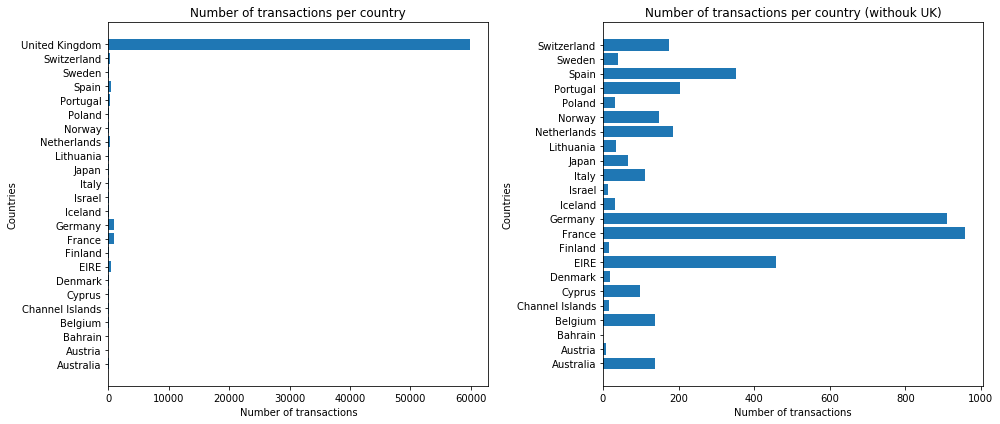

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

country_group = data[['Country', 'InvoiceNo']].groupby('Country').count()
country_group.sort_values('InvoiceNo', axis=0, ascending=False)

ax[0].barh(y = country_group.index, width = 'InvoiceNo', data = country_group)
ax[0].set_ylabel('Countries')
ax[0].set_xlabel('Number of transactions')
ax[0].set_title('Number of transactions per country')

country_group = country_group[country_group.index != 'United Kingdom']

ax[1].barh(y = country_group.index, width = 'InvoiceNo', data = country_group[country_group.index != 'United Kingdom'])
ax[1].set_ylabel('Countries')
ax[1].set_xlabel('Number of transactions')
ax[1].set_title('Number of transactions per country (withouk UK)')

plt.tight_layout()

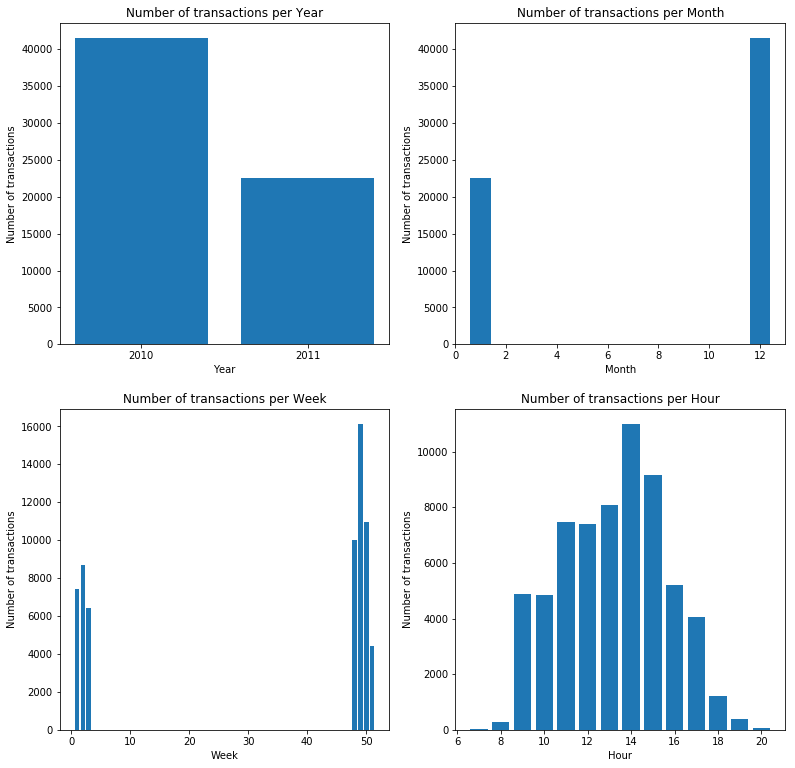

In [9]:
# Plot number of transactions per year/month/week/hour
groups = np.array([['Year', 'Month'], ['Week', 'Hour']])

fig, ax = plt.subplots(groups.shape[0], groups.shape[1], figsize=(13, 13))

for i in range(0, groups.shape[0]):
    for j in range(0, groups.shape[1]):
        grp_data = data[[groups[i,j], 'InvoiceNo']].groupby([groups[i,j]]).count()
        grp_data.reset_index(level=0, inplace=True)
        ax[i,j].bar(x = grp_data.iloc[:, 0], height = 'InvoiceNo', data = grp_data, align = 'center')
        if groups[i,j] == 'Year':
            ax[i,j].set_xticks(grp_data.iloc[:, 0])
            ax[i,j].set_xticklabels(grp_data.iloc[:, 0])
        ax[i,j].set_ylabel('Number of transactions')
        ax[i,j].set_xlabel(groups[i,j])
        ax[i,j].set_title('Number of transactions per {}'.format(groups[i,j]))

plt.show()

We have data only for December 2010 and January 2011 hance the distribution of the sales.

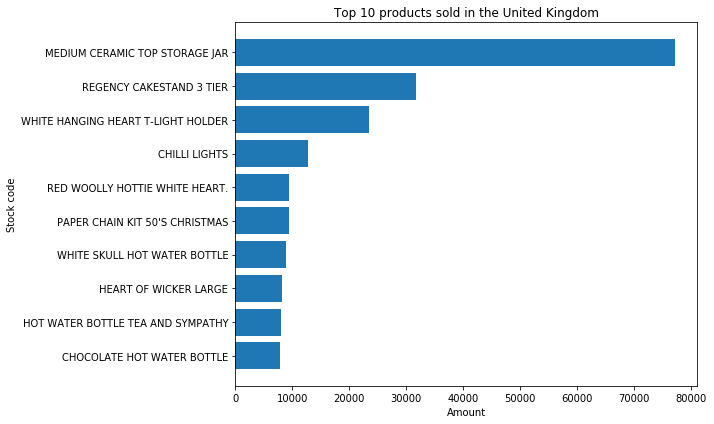

In [10]:
# filter unrelevant products
fltr = ['DOT', 'POST', 'M', 'DOTCOM POSTAGE', 'AMAZON FEE']
top_n = 10

fig, ax = plt.subplots(figsize=(10, 6))

grp_data = data[data['Country'] == 'United Kingdom']
grp_data = grp_data[~grp_data['Description'].isin(fltr)]
grp_data = grp_data[['Description', 'Amount']].groupby(['Description']).sum().sort_values(by='Amount', ascending=False)        
grp_data = grp_data[0:top_n]    
grp_data = grp_data.reset_index()

ax.barh(y=grp_data.index, width='Amount', data=grp_data)
ax.invert_yaxis()
ax.set_yticks(range(0,top_n))
ax.set_yticklabels(grp_data['Description'].tolist())
ax.set_ylabel('Stock code')        
ax.set_xlabel('Amount')                
ax.set_title('Top 10 products sold in the United Kingdom')
        
plt.tight_layout()
plt.show()

### 4.) Step: Recomender systems

#### Recommender systems fall into a number of different categories:
    1.) Collaborative filtering  
    2.) Content-based approach  
    3.) Hybrid models (CF + Content-based approach)  
    
#### Collaborative filtering can be further broken down into three main sub-categories:  
    1.1.) Neighbourhood-based approach  
    1.2.) Model-based approach  
    1.3.) Hybrid-models

#### 4.1.) Collaborative filtering

Collaborative filtering methods make use of users’ past behaviour in order to recommend items. Ex: If Jack loves A and B, and Jill loves A, B, and C, then Jack is more likely to love C. As a result, our task is to discover patterns in observed preference behaviour (e.g. purchase history) and predict new preferences based on those patterns. This approach does not rely on on item or user attributes.

##### 4.1.1) Neighbourhood based approach

Neighbourhood-based (or Memory-based) works by comparing users or items based on the similarity of user purchases. We need to make measurements of user preferences. In our case, user preferences are
number of products individual users bought. The result is a sparse data set. This is an important detail because, when dealing with very large data sets, storing them into appropriate data structures can help us significantly increase computation time.

In [11]:
# Mapping user actions to numerical scores
user_product_df = data[['StockCode', 'CustomerID', 'Amount']].groupby(['StockCode', 'CustomerID']).count()
user_product_df = user_product_df.reset_index()
user_product_df = user_product_df[user_product_df['CustomerID'] != '00000']
user_product_df = pd.pivot_table(user_product_df, index='CustomerID', columns='StockCode', values='Amount')
user_product_df.head(5)

StockCode,10002,10120,10123C,10124A,10124G,10125,10133,10135,11001,15034,...,90214J,90214K,90214M,90214R,90214S,90214V,BANK CHARGES,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Item-based Collaborative Filtering

In our newly constructed dataframe, we can consider our columns as feature vectors. As a result, we can measure the distance between these vectors using various measures of similarity and distance. 

##### Measures of distance or similarity:  
    a.) Euclidean distance  
    b.) Pearson Correlation (not a distance)
    c.) Cosine Similarity (not a distance)  
    
We now have a set of measures for computing the similarity between products. We can use these to produce a ranked list of the best matches (most similar products) for a target product.

In [12]:
from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats

#Create sparse matrix
def to_sparse(data):
    
    d = data[['StockCode', 'CustomerID', 'Amount']].groupby(['StockCode', 'CustomerID']).count()
    d = d.reset_index()
    d = d[d['CustomerID'] != '00000']
    pivot = pd.pivot_table(d, index='CustomerID', columns='StockCode', values='Amount')
    pivot = pivot.dropna(axis=1, how='all')
    cols = pivot.columns
    pivot = pivot.fillna(0)
    matrix = lil_matrix(pivot)
    return matrix,cols

matrix, cols = to_sparse(data)

# Calculate similarities
def get_sims(matrix, col_index):
    
    cosine = lambda x,y: 1-spatial.distance.cosine(x,y)
    euclidean = lambda x,y: spatial.distance.euclidean(x,y)    
    pearson = lambda x,y: float(stats.pearsonr(x,y)[0])
    
    corrs = []
    col = matrix[:,col_index].todense()    
    col_nums = range(0, matrix.shape[1])

    def calculate(i):    
        tmp_col = matrix[:,i].todense()            
        return [i, euclidean(col, tmp_col), cosine(col, tmp_col), pearson(col, tmp_col)]
        
    sims = list(map(calculate, col_nums))
        
    return pd.DataFrame(data=sims, index=cols, columns=['ColNo', 'Euclidean', 'Cosine', 'Pearson'])

To make a recommendation for a user, look at their most bought items and aggregate items similar to those.

In [13]:
#Return top items bought (number of times an item was bought) for a particular customer
def get_most_bought_items(data, customer_id, items = 5):
    tmp = data.groupby(['CustomerID','StockCode'])['InvoiceNo'].count()
    tmp = tmp.loc[customer_id].sort_values(ascending = False)[0:items].index
    return list(tmp)

customer_id = '17850'
items = get_most_bought_items(data, customer_id)
print('Most frequently bought item by customer: {} is product: {}'.format(customer_id, items[0]))


def get_recomandation(data, product_id, nr_of_prod = 20, measure = 'Euclidean'):
    
    matrix, cols = to_sparse(data)
    product = list(cols).index(product_id)
    most_similar = get_sims(matrix = matrix, col_index = product)
    most_similar = most_similar.join(data[['StockCode', 'Description']].groupby(['StockCode', 'Description']).count())
    most_similar.reset_index(inplace=True)
    result = most_similar.sort_values(by=[measure], ascending=False)[0:nr_of_prod]
    
    return result

print('Based on item similarity (measured by Euclidean distance), the following products can be recomended for him:')
get_recomandation(data, product_id = items[0], nr_of_prod = 5, measure = 'Euclidean')

Most frequently bought item by customer: 17850 is product: 85123A
Based on item similarity (measured by Euclidean distance), the following products can be recomended for him:


,StockCode,Description,ColNo,Euclidean,Cosine,Pearson
1483,22727,ALARM CLOCK BAKELIKE RED,1473,31.240999,0.072023,0.004605
1482,22726,ALARM CLOCK BAKELIKE GREEN,1472,31.144823,0.084198,0.014761
1991,79321,CHILLI LIGHTS,1966,30.951575,0.128004,0.077090
2595,POST,POSTAGE,2569,30.935417,0.010303,-0.072093
1197,22423,REGENCY CAKESTAND 3 TIER,1188,30.380915,0.164315,0.057087


##### User-based Collaborative Filtering

Similarly to our approach above, we could also calculate distance/similarity between users.
This can be done by simply switching the columns and the rows of the matrix we have used in our prevoius method.

In [14]:
user_product_df = data[['StockCode', 'CustomerID', 'Amount']].groupby(['StockCode', 'CustomerID']).count()
user_product_df = user_product_df.reset_index()
user_product_df = user_product_df[user_product_df['CustomerID'] != '00000']
user_product_df = pd.pivot_table(user_product_df, index='CustomerID', columns='StockCode', values='Amount').T
user_product_df.head(5)

CustomerID,12346,12347,12348,12356,12359,12370,12377,12383,12386,12388,...,18225,18226,18229,18233,18239,18245,18259,18260,18269,18283
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10123C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10124A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10124G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Compared to our previous approach, when we made recomandations based on product similarities, we now pursue the following steps:
    - find top N users similar to our target user  
    - find common items which they all frequently bought
    - recommend items by aggregating products similar users bought but our user didn't. A possible aggregation method would    be to weigh products by according to user similarities.
    
Note : User-based filtering relies on computing the similarity against every user. With millions of users this might be a problem!

### 5.) Step: Market Basket Analysis

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

#### Association analysis

Is a methodology useful for discovering interesting relationships hidden in large data sets. The uncovered relationships can be represented in the form association rules or sets of frequent items. Association rules are normally written like this: {Beer} -> {Bred} which means that there is a strong relationship between customers that purchased beer and also purchased bread in the same transaction. In the above example, the {Beer} is the antecedent and the {Bread} is the consequent. Both antecedents and consequents can have multiple items. In other words, {Bread, Gum} -> {Beer, Chips} is a valid rule.

   __Support__: is the relative frequency that the rules show up. In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.

   __Confidence__: is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where Bread and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

   __Lift__: is the ratio of the observed support to that expected if the two rules were independent. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

In [15]:
# 1st step is to create the basket dataframe. We can't use stock codes as some items have two codes
basket = data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# There are a lot of zeros in the data. We also need to make sure any positive values are converted to a 1 
# and anything less the 0 is set to 0.
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [17]:
# We use the mlextend library to calculate associations using the apriori algorithm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(basket_sets, min_support = 0.04, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Selecting the important parameters for analysis
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules[['antecedants', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedants,consequents,support,confidence,lift
0,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.047233,0.483871,6.364764
1,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.047233,0.621302,6.364764
2,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART OF WICKER SMALL),0.040486,0.266272,2.727756
3,(HEART OF WICKER SMALL),(WHITE HANGING HEART T-LIGHT HOLDER),0.040486,0.414747,2.727756
4,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.040936,0.269231,4.244681


In [18]:
# We could filter our results further by using more restrictive values for lift and confidence
rules[(rules['lift'] >= 10) & (rules['confidence'] >= 0.4)]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.057580,0.064327,0.041835,0.726562,11.294744,0.038131,3.421888
11,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.064327,0.057580,0.041835,0.650350,11.294744,0.038131,2.695322


The accuracy of our analysis could be further improved by looking at products purchased in different countries. Nontheless, these results could be a starting point for making product recomandations.